<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[FX Business Day Strategy](Introduction.ipynb) › Part 3: Interactive Strategy Development
***

# Interactive Strategy Development

Now that we've validated the basic concept behind our trading strategy, we can write Pandas code to backtest the idea more fully using Moonshot. Based on the previous plot, we will create a strategy which sells EUR.USD from 3 AM to 11 AM New York time (9 AM to 5 PM Europe time), then buys EUR.USD from 11 AM to 4 PM.

The sequence of steps needed for any Moonshot strategy is to create a DataFrame of signals, assign target weights to the signals, convert the DataFrame of target weights (what we want to own) to a DataFrame of positions (what we actually own), and calculate returns for the positions. 

To start, load prices again:

In [1]:
from quantrocket import get_prices
prices = get_prices("fiber-1h", sids="FXEURUSD", fields="Close")

## Prices to signals

Since our signals are based on time, the first step is to get a DataFrame of times for calculating our signals. We extract the times from the prices index and use `apply` to broadcast them to match the shape of the DataFrame:

In [2]:
closes = prices.loc["Close"]
        
# Get a DataFrame of times
times = closes.index.get_level_values("Time")
times = closes.apply(lambda x: times)
times.head()

Sid                  FXEURUSD
Date       Time              
2005-03-10 00:00:00  00:00:00
           01:00:00  01:00:00
           02:00:00  02:00:00
           03:00:00  03:00:00
           04:00:00  04:00:00

Next we get boolean DataFrames indicating when we want to buy and sell EUR.USD:

In [3]:
# Sell EUR.USD when Europe is open
sell_eur = (times >= "03:00:00") & (times < "11:00:00")

# Buy EUR.USD when Europe is closed and US is open
buy_eur = (times >= "11:00:00") & (times < "16:00:00")

By convention, a signals DataFrame consists of 1s, 0s, and -1s to indicate long, cash, and short. We create such a DataFrame from our boolean DataFrames: 

In [4]:
import pandas as pd

# Construct 1s and -1s with which to create our signals DataFrame
ones = pd.DataFrame(1, index=closes.index, columns=closes.columns)
minus_ones = pd.DataFrame(-1, index=closes.index, columns=closes.columns)

# Create int signals from booleans
signals = minus_ones.where(sell_eur, ones.where(buy_eur, 0))

Finally, noting that the FX market is open for part of the weekend, we limit the signals to weekdays:

In [5]:
are_weekdays = closes.index.get_level_values("Date").day_name().isin([
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday"
])
are_weekdays = signals.apply(lambda x: are_weekdays)

signals = signals.where(are_weekdays, 0)

## Signals to target weights

Target weights represent the proportion of capital to assign to each signal. Since we are only trading 1 instrument, we assign all of our capital to it, meaning our target weights are identical to our signals:

In [6]:
target_weights = signals.copy()

## Target weights to positions

We will assume that we enter the position immediately at the time of the signal (alternatively we could have generated our signals one period earlier and entered the position in the following period):

In [7]:
positions = target_weights.copy()

## Positions to gross returns

Our gross returns are the percent change of EUR.USD multiplied by the position. We `shift()` the position because the return doesn't accrue until the period after we enter the position:

In [8]:
gross_returns = closes.pct_change() * positions.shift()

We can plot the returns to see the performance before slippage and commissions:

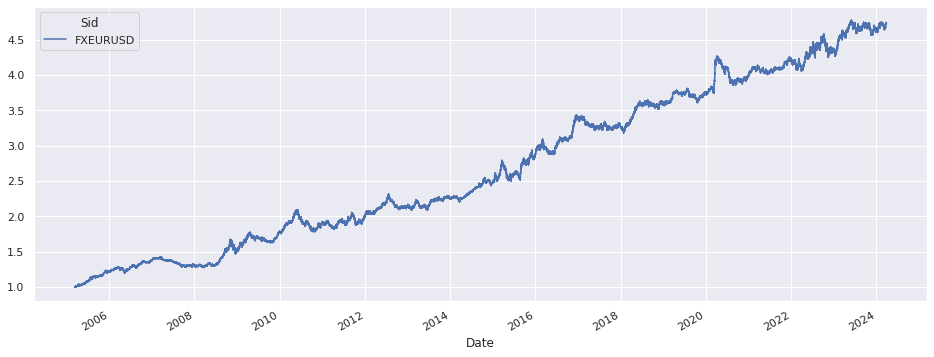

In [9]:
cum_returns = (1 + gross_returns).cumprod()
cum_returns.droplevel("Time").plot();

***

## *Next Up*

Part 4: [Moonshot Backtest](Part4-Moonshot-Backtest.ipynb)